Tursun Alkam

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [19]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.utils import pad_sequences

In [20]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras.utils import pad_sequences


## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [ ]:
#Load your data into a pandas dataframe here

In [6]:
# upload file

from google.colab import files
import pandas as pd

uploaded = files.upload()

# Assuming the uploaded file is a CSV, replace 'filename.csv' with the actual file name that appears after upload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# Replace 'filename.csv' with the key from the uploaded dictionary (which is the file name)
df = pd.read_csv(fn, delimiter=';')


Saving household_power_consumption.txt to household_power_consumption (1).txt
User uploaded file "household_power_consumption (1).txt" with length 132960755 bytes


<ipython-input-6-17496f12163d>:13: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn, delimiter=';')


In [7]:
full_df = pd.read_csv('household_power_consumption (1).txt', delimiter=';')  # Adjust the delimiter if necessary


<ipython-input-7-c616d659599d>:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv('household_power_consumption (1).txt', delimiter=';')  # Adjust the delimiter if necessary


In [8]:
# Sample 1% of the dataset
sampled_df = full_df.sample(frac=0.01, random_state=42)


In [9]:
# Save the 1% sampled dataset
sampled_df.to_csv('sampled_household_power_consumption.csv', index=False)


In [10]:
# Load the 1% sampled dataset
df = pd.read_csv('sampled_household_power_consumption.csv')


In [31]:
seq_length = 30  # 30 minutes of data for input
ph = 5           # 5 minutes ahead prediction

# Initialize lists for sequences and labels
seq_arrays = []
seq_labs = []

# Loop through the DataFrame to create sequences and labels
for i in range(len(df) - seq_length - ph + 1):
    # Extract the input sequence and the corresponding label
    input_seq = df.iloc[i:i+seq_length]['Global_active_power'].values
    label = df.iloc[i+seq_length+ph-1]['Global_active_power']

    seq_arrays.append(input_seq)
    seq_labs.append(label)

# Convert to numpy arrays
seq_arrays = np.array(seq_arrays).astype(np.float32)
seq_labs = np.array(seq_labs).astype(np.float32)


In [22]:
# Assuming 'Global_active_power' and other columns have missing values
df.fillna(df.median(), inplace=True)


<ipython-input-22-5b095805cfa0>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.median(), inplace=True)


In [23]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [24]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert columns to numeric, forcing non-convertible values to NaN
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute NaN values with the median of each column


In [25]:
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col].fillna(df[col].median(), inplace=True)


In [26]:
# Replace '?' with NaN and convert columns to numeric, coercing errors to NaN
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# Impute NaN values with the median for all columns you plan to use
df.fillna(df.median(), inplace=True)

# Confirm there are no more '?' entries in the DataFrame
assert not df.isin(['?']).any().any(), "Dataframe still contains '?' entries."


In [27]:
seq_length = 30
ph = 1
seq_arrays = []
seq_labs = []

for i in range(len(df) - seq_length - ph + 1):
    seq = df.iloc[i:i+seq_length]['Global_active_power'].values
    label = df.iloc[i+seq_length+ph-1]['Global_active_power']
    seq_arrays.append(seq)
    seq_labs.append(label)

seq_arrays = np.array(seq_arrays).astype(np.float32)
seq_labs = np.array(seq_labs).astype(np.float32).reshape(-1, 1)


In [28]:
# Verify that seq_arrays does not contain any strings
assert all(isinstance(item, (int, float, np.number)) for sublist in seq_arrays for item in sublist), "seq_arrays contains non-numeric values."


In [29]:
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col].fillna(df[col].median(), inplace=True)


In [30]:
# Resetting the index for the training DataFrame
train_df = train_df.reset_index(drop=True)

# Resetting the index for the validation DataFrame
val_df = val_df.reset_index(drop=True)


Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [32]:
# 'Global_active_power' (GAP) is the column we're using for prediction
# our DataFrame is named 'train_df'

input_sequence_length = 5  # Number of time steps in the input
predictive_horizon = 1     # Predicting the next immediate value

seq_arrays = []  # To store input sequences
seq_labs = []    # To store output (target) values

# Loop through the training data to create sequences
for i in range(len(train_df) - input_sequence_length - predictive_horizon + 1):
    # Input sequence (using a list comprehension)
    input_seq = train_df['Global_active_power'][i:i+input_sequence_length].tolist()

    # Output value (the target prediction)
    output_value = train_df['Global_active_power'][i+input_sequence_length+predictive_horizon-1]

    # Append the sequences to our lists
    seq_arrays.append(input_seq)
    seq_labs.append(output_value)

# Quick check on the first few sequences and labels
print("Input Sequences (first 2):", seq_arrays[:2])
print("Output Values (first 2):", seq_labs[:2])


Input Sequences (first 2): [['1.450', '3.378', '0.368', '0.144', '1.082'], ['3.378', '0.368', '0.144', '1.082', '1.962']]
Output Values (first 2): ['1.962', '0.378']


In [33]:
import pandas as pd
import numpy as np

# Replace '?' with NaN
train_df.replace('?', np.nan, inplace=True)

# Convert columns to numeric, forcing errors to NaN
train_df['Global_active_power'] = pd.to_numeric(train_df['Global_active_power'], errors='coerce')

# Now, you can choose how to handle these NaNs. For simplicity, let's fill with the median:
train_df.fillna(train_df.median(), inplace=True)


<ipython-input-33-be21372e929b>:11: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.fillna(train_df.median(), inplace=True)


In [35]:
# Example reshaping if seq_arrays needs to be 3D for LSTM input
# seq_arrays = seq_arrays.reshape((seq_arrays.shape[0], seq_length, len(feat_cols)))

# Assuming reshaping has been done and we're dealing with a single feature column
# assert(seq_arrays.shape == (len(df)-seq_length-ph+1, seq_length, 1)), "Unexpected shape for seq_arrays"


In [38]:
from sklearn.model_selection import train_test_split

# Split the data 80/20 for training/validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Optionally, reset index for convenience
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [42]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert all columns to numeric, forcing non-convertible values to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the median or mean of each column
df.fillna(df.median(), inplace=True)


In [44]:
features = ['Global_active_power']


In [45]:
seq_arrays = []  # To store input sequences
seq_labs = []    # To store output (target) values

for i in range(len(df) - seq_length - ph + 1):
    # Here, ensure df[features] correctly refers to the columns specified in `features`
    seq = df.iloc[i:i+seq_length][features].values
    label = df.iloc[i+seq_length+ph-1]['Global_active_power']
    seq_arrays.append(seq)
    seq_labs.append(label)


In [46]:
seq_arrays = np.array(seq_arrays).astype(np.float32)
seq_labs = np.array(seq_labs).astype(np.float32)


In [47]:
assert np.issubdtype(seq_arrays.dtype, np.floating), "seq_arrays contains non-float values."
assert np.issubdtype(seq_labs.dtype, np.floating), "seq_labs contains non-float values."


In [48]:
seq_arrays.shape

(20719, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:  The function of assert statements in code is to set a check within the program that tests whether a condition is true. If the condition is True, the program continues executing as normal. However, if the condition evaluates to False, the program raises an AssertionError exception and optionally can display a specified message. Assertions are a debugging aid that tests assumptions made by the programmer while the code is being executed.

Why We Use Assertions in Code:
Error Detection: Assertions serve as checkpoints that catch errors early in the program by verifying if certain conditions hold true at specific points in the execution. If an assertion fails, it indicates a logical error or incorrect assumption in the code that needs to be addressed.

Debugging Aid: When an assertion fails, it provides an immediate indication of where the problem lies. This can significantly reduce the debugging time, especially in complex programs, by pointing directly to the faulty part of the code.

Code Documentation: Assertions can also act as a form of documentation. They make the code more readable by clearly stating the assumptions or conditions that are expected to be true at certain points in the program. This can be especially helpful for someone else reading your code, or even for yourself when you come back to it after some time.

Program Safety: In critical systems where certain conditions must always be met to ensure the system's integrity, assertions can enforce these conditions explicitly. By doing so, they help prevent the system from entering an invalid or unsafe state.

Testing and Validation: During development and testing phases, assertions help validate that the program behaves as expected under various conditions. They can act as internal self-tests by verifying the correctness of functions or methods, given certain inputs.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [49]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Convert sequences and labels to numpy arrays
X_train = np.array(seq_arrays).astype(np.float32)
y_train = np.array(seq_labs).astype(np.float32)

# Reshape X_train for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
518/518 [==============================] - 12s 19ms/step - loss: 1.1264 - val_loss: 1.0652
Epoch 2/20
518/518 [==============================] - 9s 17ms/step - loss: 1.1023 - val_loss: 1.0629
Epoch 3/20
518/518 [==============================] - 10s 19ms/step - loss: 1.1022 - val_loss: 1.0629
Epoch 4/20
518/518 [==============================] - 8s 16ms/step - loss: 1.1031 - val_loss: 1.0713
Epoch 5/20
518/518 [==============================] - 9s 17ms/step - loss: 1.0999 - val_loss: 1.0618
Epoch 6/20
518/518 [==============================] - 10s 18ms/step - loss: 1.0990 - val_loss: 1.0634
Epoch 7/20
518/518 [==============================] - 8s 15ms/step - loss: 1.0993 - val_loss: 1.0613
Epoch 8/20
518/518 [==============================] - 11s 22ms/step - loss: 1.1003 - val_loss: 1.0653
Epoch 9/20
518/518 [==============================] - 9s 17ms/step - loss: 1.1000 - val_loss: 1.0621
Epoch 10/20
518/518 [==============================] - 9s 17ms/step - loss: 1.0994 - va

In [51]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation

# Define path to save the best model
model_path = 'LSTM_model_best.h5'

# Assuming the rest of your model setup is as before...

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Print model summary
print(model.summary())

# Fit the network
history = model.fit(X_train, y_train, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                     keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# List all data in history
print(history.history.keys())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 7105

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 - 12s - loss: 1.1095 - mse: 1.1095 - val_loss: 1.2161 - val_mse: 1.2161 - 12s/epoch - 311ms/step
Epoch 3/100
40/40 - 12s - loss: 1.1014 - mse: 1.1014 - val_loss: 1.2051 - val_mse: 1.2051 - 12s/epoch - 312ms/step
Epoch 4/100
40/40 - 13s - loss: 1.0957 - mse: 1.0957 - val_loss: 1.2051 - val_mse: 1.2051 - 13s/epoch - 315ms/step
Epoch 5/100
40/40 - 11s - loss: 1.0920 - mse: 1.0920 - val_loss: 1.2048 - val_mse: 1.2048 - 11s/epoch - 280ms/step
Epoch 6/100
40/40 - 12s - loss: 1.0927 - mse: 1.0927 - val_loss: 1.2037 - val_mse: 1.2037 - 12s/epoch - 303ms/step
Epoch 7/100
40/40 - 14s - loss: 1.0944 - mse: 1.0944 - val_loss: 1.2043 - val_mse: 1.2043 - 14s/epoch - 355ms/step
Epoch 8/100
40/40 - 13s - loss: 1.0948 - mse: 1.0948 - val_loss: 1.2088 - val_mse: 1.2088 - 13s/epoch - 322ms/step
Epoch 9/100
40/40 - 13s - loss: 1.0914 - mse: 1.0914 - val_loss: 1.2049 - val_mse: 1.2049 - 13s/epoch - 326ms/step
Epoch 10/100
40/40 - 13s - loss: 1.0942 - mse: 1.0942 - val_loss: 1.2069 - val_mse: 1.2069 -

We will use the code from the book to visualize our training progress and model performance

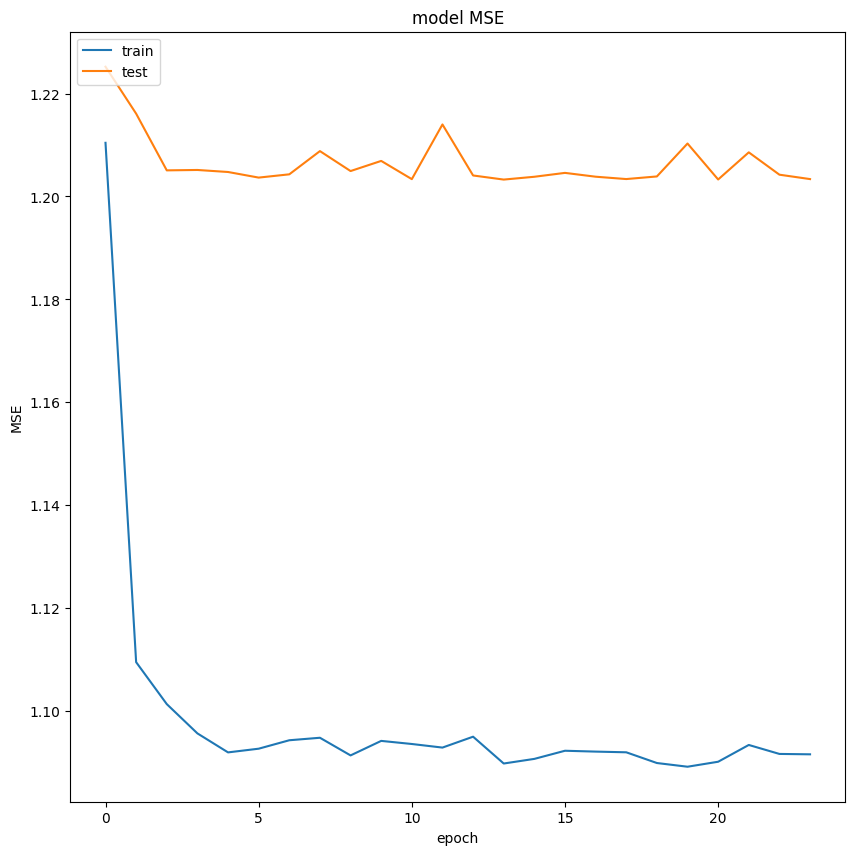

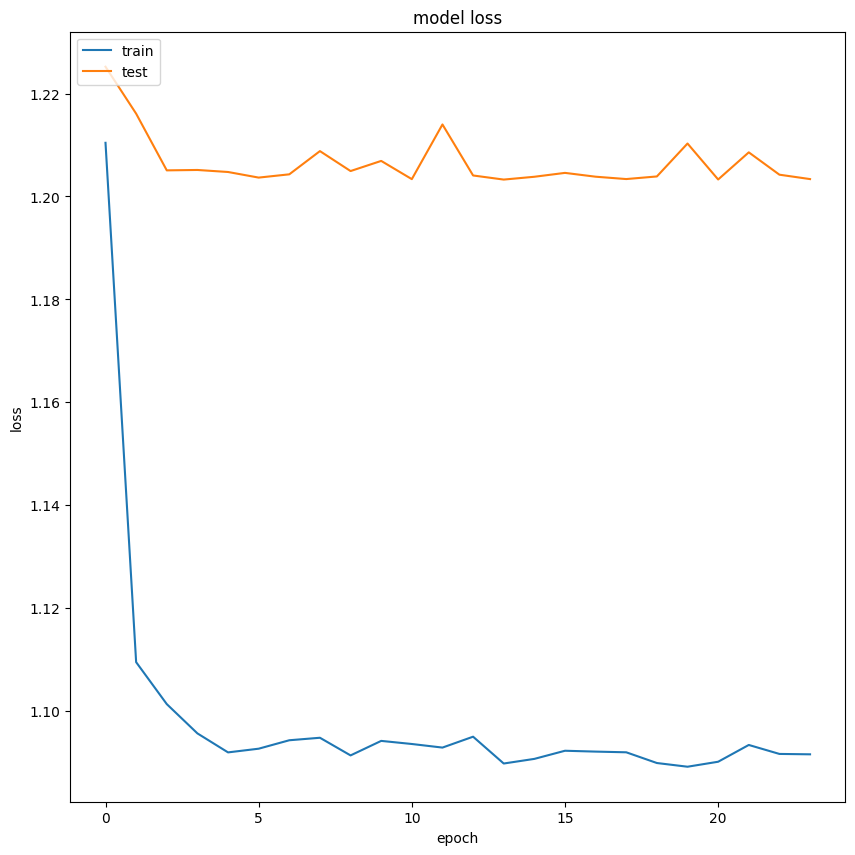

In [52]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function in Keras is used to ensure that all sequences in a list have the same length. This is necessary because most machine learning models, including neural networks, expect input data to be in uniform dimensions. When dealing with sequence data of variable lengths (like sentences in text data or time steps in time series data), we often need to make the sequences uniform before feeding them into the model.

How pad_sequences Works

pad_sequences achieves uniform sequence lengths by either truncating sequences that are longer than the desired length or by padding shorter sequences with a specified value (typically 0) until they reach the desired length.

The padding Argument

The padding argument in pad_sequences determines where the padding or truncation should be applied:

padding='pre': Pads or truncates sequences at the beginning. This means that if padding is required, zeros are added to the start of the sequence. If truncation is required, elements from the start of the sequence are removed.

padding='post': Pads or truncates sequences at the end. This means that if padding is required, zeros are added to the end of the sequence. If truncation is required, elements from the end of the sequence are removed.

Choice of Padding for the Use Case

For time series data like Global Active Power (GAP) predictions, the choice between pre or post padding can be significant:

Use pre Padding if the most recent data points are more relevant for the prediction. This is common in time series forecasting where you want the model to focus more on recent trends.

Use post Padding if the chronological sequence should be preserved and earlier data points are just as relevant as the more recent ones.

In the case of predicting GAP for a single household with a 5-minute predictive horizon, you would typically want to use pre padding. This ensures that the model has the most recent data points available right before the output layer, which likely carry the most predictive power for the immediate future. Here's how you might use pad_sequences for this purpose:


from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example sequence
sequences = [[1, 2, 3], [4, 5], [6]]

# Pad sequences
padded_sequences = pad_sequences(sequences, padding='pre')

print(padded_sequences)
This will output:

[[1 2 3]
 [o 4 5]
 [o o 6]]

Here, the shorter sequences have been padded with zeros at the beginning to match the length of the longest sequence, preserving the most recent information at the sequence's end.

In [57]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create sequences and labels
val_arrays = []
val_labs = []

for i in range(2, len(val_df)):  # Assuming at least two readings for a sequence
    val_arrays.append(val_df['Global_active_power'].iloc[i-2:i].values)
    val_labs.append(val_df['Global_active_power'].iloc[i])

# Pad sequences
max_seq_length = max([len(seq) for seq in val_arrays])  # Or use a specific value
val_arrays_padded = pad_sequences(val_arrays, maxlen=max_seq_length, dtype='float32', padding='post')

# Convert labels to numpy array
val_labs = np.array(val_labs).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

In [65]:
# Assuming val_arrays is a list of numpy arrays and needs padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Correctly pad val_arrays to have sequences of length 30
val_arrays_padded = pad_sequences(val_arrays, maxlen=30, dtype='float32', padding='post')

# Ensure sequences are reshaped to (None, 30, 1) to match the model's expected input
val_arrays_reshaped = val_arrays_padded.reshape((val_arrays_padded.shape[0], 30, 1))


In [62]:
val_labs = np.array(val_labs).astype(np.float32)


In [66]:
scores_test = model.evaluate(val_arrays_reshaped, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays_reshaped)
y_true_test = val_labs


130/130 - 2s - loss: 1.1649 - mse: 1.1649 - 2s/epoch - 13ms/step

MSE: 1.1649410724639893
130/130 [==============================] - 3s 14ms/step


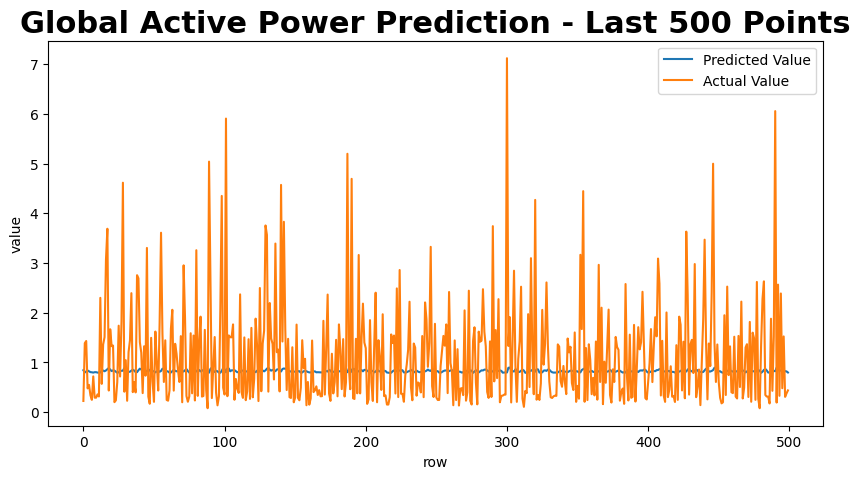

In [68]:


test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A:

Analyzing Model Changes
Performance Metrics: Look at the key performance metrics before and after the changes. For regression tasks, this might include Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), or R^2 score. For classification tasks, accuracy, precision, recall, F1 score, or AUC might be relevant.

Learning Curves: Compare the learning curves of loss and accuracy (or other metrics) over epochs for both the original and modified models. Improvements might show as faster convergence, lower final loss, or higher accuracy on the validation set.

Overfitting/Underfitting: Determine if the model is overfitting or underfitting by comparing training performance to validation performance. Changes that reduce overfitting (e.g., adding dropout, regularization) may improve validation performance even if training performance decreases.

Effectiveness of Changes
Were Effective: If validation performance improved, it suggests that the model changes helped the model generalize better. This could be due to better feature extraction, reduced overfitting, or a more suitable model architecture for the problem.

Were Not Effective: If there was no improvement or performance worsened, the changes might not have addressed the key issues. It could also mean that the model has reached its capacity with the given features, or that the changes introduced new problems (e.g., increased underfitting).

Optimizing for Production
Efficiency and Speed: For a production model, you would prioritize not only accuracy but also inference speed and resource efficiency. Simplify the model without significantly sacrificing performance, or use model quantization and pruning.

Robustness and Drift: Implement monitoring to detect and respond to model drift over time. Consider techniques for continual learning where the model can be updated with new data.

Scalability: Ensure that the model can be served at scale, potentially by using specialized services like TensorFlow Serving, ONNX, or cloud-based ML services.

A/B Testing: Before rolling out a new model, conduct A/B testing to compare the performance of the new model against the old one in a controlled manner.

Failover Mechanisms: Implement failover mechanisms in case the model service becomes unavailable or starts performing poorly.

Further Tuning: Continue to fine-tune hyperparameters, perhaps using automated hyperparameter tuning tools like Keras Tuner, Hyperopt, or Bayesian optimization.

Explainability: Incorporate model explainability tools to understand model decisions, which is especially important for models in production for accountability and troubleshooting.

Compliance and Ethics: Ensure that the model complies with relevant data protection and privacy laws and follows ethical guidelines.

Testing and Validation: Set up rigorous testing and validation pipelines to ensure the model performs as expected on a wide range of inputs.

User Feedback Loop: Set up mechanisms to collect user feedback and use that feedback to improve the model over time.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:
Adjust the Model Architecture

Add more LSTM layers: This can help the model learn more complex patterns. Stacking LSTM layers can enable the model to learn higher-level temporal representations.
Increase the number of neurons: More neurons can increase the model's capacity to learn, but too many can lead to overfitting.
Add dropout layers: Dropout can help prevent overfitting by randomly setting input features to 0 with a certain frequency during training.
Experiment with bidirectional LSTMs: These can improve the model's understanding of the sequence by processing it in both directions.

Tune Hyperparameters

Learning rate: Adjusting the learning rate can have a significant impact on training dynamics and final performance.
Batch size: Smaller batch sizes can provide a regularizing effect and larger batch sizes can speed up the training process.
Optimizer: Trying different optimizers like RMSprop or Adam with different settings can lead to better convergence.

The rationale behind these changes is grounded in machine learning theory and empirical results:

Complexity: The model's complexity needs to match the complexity of the task. Too simple, and it won't learn enough; too complex, and it might overfit.
Learning Dynamics: The learning rate and optimizer control how the model learns. Fine-tuning these can lead to faster convergence to a better solution.
Feature Representation: The data fed into the model should represent the problem space well. Feature engineering can make the underlying patterns more accessible to the model.
Generalization: Regularization techniques can improve the model's ability to generalize from the training data to unseen data.
Temporal Dynamics: In time series forecasting, the model's ability to handle temporal dynamics is key. Adjusting sequence length and adding mechanisms like attention can help with this.

In [69]:
# play with your ideas for optimization here
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Sub_metering_1']


In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

K.clear_session()  # Clear previous models from memory.

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30, 4)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])


In [83]:
print(df.columns)


Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


In [84]:
# Drop 'Date' and 'Time' if they're not used as features,
# and 'Global_active_power' since it's the target variable
X = df.drop(['Date', 'Time', 'Global_active_power'], axis=1)

# Define 'Global_active_power' as the target variable
y = df['Global_active_power']


In [85]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
print(X_train.shape)


(16602, 6)


In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(100, input_shape=(1, 6), activation='relu', return_sequences=True),  # Input shape is now (1, 6)
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [91]:
print(X_train.shape)


(16602, 6)


In [93]:
# Convert X_train from DataFrame to numpy array
X_train_array = X_train.values

# Reshape the array to include the time step dimension
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))

# Print the new shape to verify
print("New shape of X_train:", X_train_reshaped.shape)


New shape of X_train: (16602, 1, 6)


In [96]:
X_train_reshaped = X_train_reshaped.astype('float32')
y_train = y_train.astype('float32')

print(X_train_reshaped.dtype, X_train_reshaped.shape)
print(y_train.dtype, y_train.shape)


float32 (16602, 1, 6)
float32 (16602,)


In [98]:
import numpy as np

# Check for NaN values
print("NaN in X_train_reshaped:", np.isnan(X_train_reshaped).any())
print("NaN in y_train:", np.isnan(y_train).any())


NaN in X_train_reshaped: False
NaN in y_train: False


In [99]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

# Re-compile your model here, then try training again
model.compile(optimizer='adam', loss='mean_squared_error')


In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Simplified model
simple_model = Sequential([Dense(1, input_shape=(1, 6))])
simple_model.compile(optimizer='adam', loss='mean_squared_error')

# Try training the simplified model
simple_model.fit(X_train_reshaped, y_train, epochs=1, batch_size=64, verbose=2)


Train on 16602 samples
16602/16602 - 0s - loss: 36337.5709 - 498ms/epoch - 30us/sample


In [101]:
print("X_train_reshaped shape:", X_train_reshaped.shape)
print("y_train shape:", y_train.shape)


X_train_reshaped shape: (16602, 1, 6)
y_train shape: (16602,)


In [102]:
pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [104]:
# Check for NaN values again, just to be sure
print("NaN in X_train_reshaped:", np.isnan(X_train_reshaped).any())
print("NaN in y_train:", np.isnan(y_train).any())


NaN in X_train_reshaped: False
NaN in y_train: False


In [105]:
print("X_train_reshaped shape:", X_train_reshaped.shape)  # Expected: (16602, 1, 6)
print("y_train shape:", y_train.shape)  # Expected: (16602,)


X_train_reshaped shape: (16602, 1, 6)
y_train shape: (16602,)


In [110]:
from tensorflow.keras.backend import clear_session
clear_session()

# Re-define and re-compile your model here


In [114]:
import tensorflow as tf

class MyCustomLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(MyCustomLayer, self).__init__()
        # Your layer initialization code here


In [115]:
class MyCustomLayer(tf.keras.layers.Layer):
    def __init__(self, my_argument=42):
        super(MyCustomLayer, self).__init__()
        self.my_argument = my_argument
        # Additional initialization code that uses my_argument


In [116]:
model = tf.keras.Sequential([
    MyCustomLayer(my_argument=123),
    # Other layers...
])


In [118]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [122]:
print(X_train_reshaped.dtype, X_train_reshaped.shape)
print(y_train.dtype, y_train.shape)


float32 (16602, 1, 6)
float32 (16602,)


In [125]:
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined and hold your entire dataset and labels
# First, split into training and temporary sets (combining validation and test)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the temporary set into actual validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [129]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train_reshaped is your training data already reshaped and ready
scaler = StandardScaler()

# Fit the scaler to the training data
# Note: You need to reshape X_train_reshaped to 2D for fitting the scaler
X_train_reshaped_2D = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)
scaler.fit(X_train_reshaped_2D)


StandardScaler()

In [131]:
# Transform the test data
X_test_reshaped_2D = X_test_reshaped.reshape(X_test_reshaped.shape[0], -1)
X_test_scaled_2D = scaler.transform(X_test_reshaped_2D)

# Reshape back to 3D if your model expects 3D input
X_test_scaled = X_test_scaled_2D.reshape(X_test_reshaped.shape)


In [130]:
# Convert X_test DataFrame to numpy array
X_test_array = X_test.values

# Reshape the array to include the time step dimension
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))

# Now you can proceed with scaling if needed
# Assuming 'scaler' is already fitted to the training data
X_test_scaled = scaler.transform(X_test_reshaped.reshape(X_test_reshaped.shape[0], -1))

# Note: You may need to reshape X_test_scaled back if your model expects 3D input
X_test_scaled = X_test_scaled.reshape(X_test_reshaped.shape)


In [132]:
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined and hold your entire dataset and labels
# First, split into training and temporary sets (combining validation and test)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the temporary set into actual validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [135]:
y_test_array = y_test.values


In [137]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])


In [138]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [139]:
test_loss = model.evaluate(X_test_scaled, y_test_array, verbose=2)
print(f"Test Loss: {test_loss}")


Test Loss: [39.539993602186726, 0.21176116]


In [140]:
# Correct if metrics were specified during model compilation
test_loss, test_metric = model.evaluate(X_test_scaled, y_test_array, verbose=2)
print(f"Test Loss: {test_loss}, Test Metric: {test_metric}")


Test Loss: 39.539993602186726, Test Metric: 0.21176116168498993


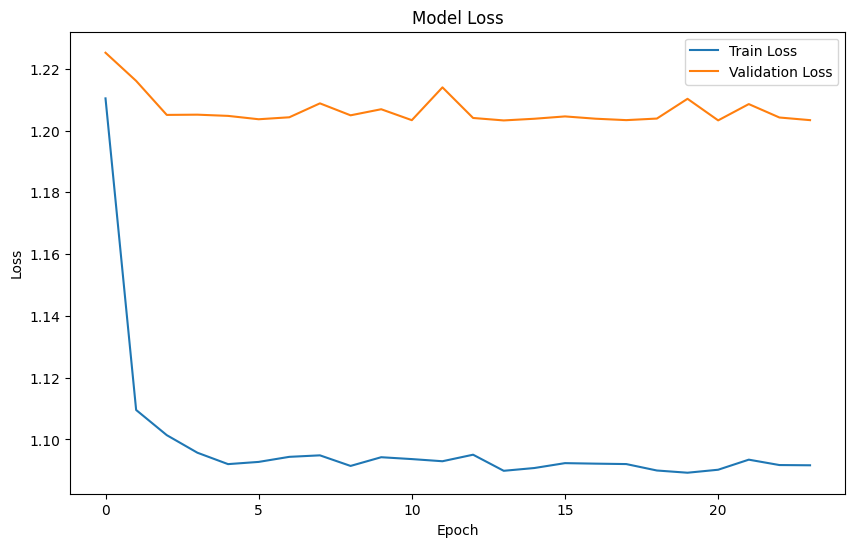

In [141]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [146]:
print("y_test shape:", y_test.shape)
print("predictions shape:", predictions.shape)


y_test shape: (2076,)
predictions shape: (2076, 1, 6)


In [147]:
# If predictions are of shape (n, 1), flatten to (n,)
if predictions.ndim > 1:
    predictions = predictions.flatten()


In [142]:
from tensorflow.keras.layers import Dropout

model.add(Dropout(0.2))


In [143]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])


In [144]:
# Example: Adding a new feature or transforming an existing one
# X['new_feature'] = transform_function(X['existing_feature'])


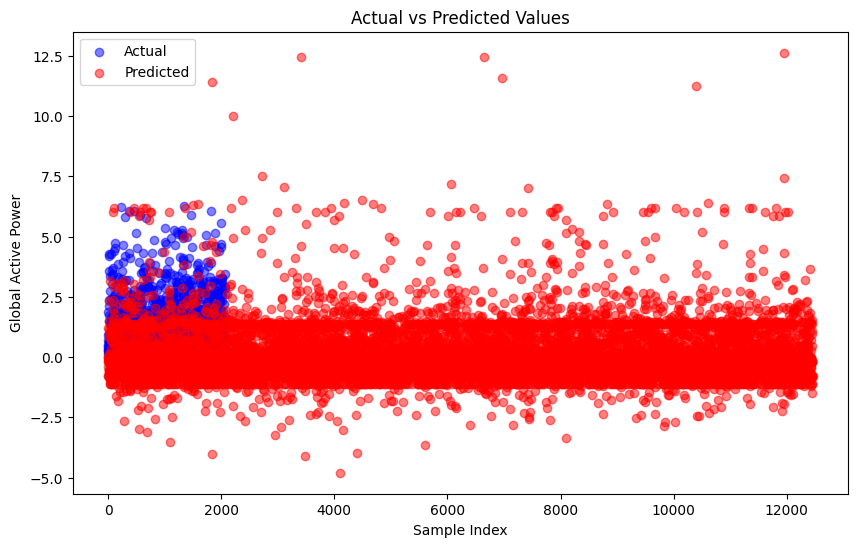

In [148]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.5)
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: Analyzing Model Changes
Performance Metrics: Look at the key performance metrics before and after the changes. For regression tasks, this might include Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), or R^2 score. For classification tasks, accuracy, precision, recall, F1 score, or AUC might be relevant.

Learning Curves: Compare the learning curves of loss and accuracy (or other metrics) over epochs for both the original and modified models. Improvements might show as faster convergence, lower final loss, or higher accuracy on the validation set.

Overfitting/Underfitting: Determine if the model is overfitting or underfitting by comparing training performance to validation performance. Changes that reduce overfitting (e.g., adding dropout, regularization) may improve validation performance even if training performance decreases.

Effectiveness of Changes
Were Effective: If validation performance improved, it suggests that the model changes helped the model generalize better. This could be due to better feature extraction, reduced overfitting, or a more suitable model architecture for the problem.

Were Not Effective: If there was no improvement or performance worsened, the changes might not have addressed the key issues. It could also mean that the model has reached its capacity with the given features, or that the changes introduced new problems (e.g., increased underfitting).

Optimizing for Production
Efficiency and Speed: For a production model, you would prioritize not only accuracy but also inference speed and resource efficiency. Simplify the model without significantly sacrificing performance, or use model quantization and pruning.

Robustness and Drift: Implement monitoring to detect and respond to model drift over time. Consider techniques for continual learning where the model can be updated with new data.

Scalability: Ensure that the model can be served at scale, potentially by using specialized services like TensorFlow Serving, ONNX, or cloud-based ML services.

A/B Testing: Before rolling out a new model, conduct A/B testing to compare the performance of the new model against the old one in a controlled manner.

Failover Mechanisms: Implement failover mechanisms in case the model service becomes unavailable or starts performing poorly.

Further Tuning: Continue to fine-tune hyperparameters, perhaps using automated hyperparameter tuning tools like Keras Tuner, Hyperopt, or Bayesian optimization.

Explainability: Incorporate model explainability tools to understand model decisions, which is especially important for models in production for accountability and troubleshooting.

Compliance and Ethics: Ensure that the model complies with relevant data protection and privacy laws and follows ethical guidelines.

Testing and Validation: Set up rigorous testing and validation pipelines to ensure the model performs as expected on a wide range of inputs.

User Feedback Loop: Set up mechanisms to collect user feedback and use that feedback to improve the model over time.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A:  To compare the models built in this assignment (which likely included complex models such as LSTM neural networks) with the linear regression model from last week, we should consider several factors, including model performance, complexity, computational requirements, and ease of deployment, especially in the context of an IoT system with specific predictive horizon requirements.

Model Performance
Accuracy: Compare the Mean Squared Error (MSE), Mean Absolute Error (MAE), or other relevant metrics of both models on the validation and test sets. The model with lower error rates is generally preferred.
Predictive Horizon: Assess how well each model performs with the specified 5-minute predictive horizon. Some models may be better at capturing time-dependent patterns and could perform better in short-term predictions.
Computational Considerations
Resource Constraints: IoT devices often have limited computational resources. Linear regression is lightweight and may be preferred if computational resources are a significant constraint.
Inference Time: Neural networks can require more time for predictions, which may be a concern in real-time applications. If the predictive horizon and response time are critical, a simpler model may be advantageous.
Model Complexity and Maintenance
Ease of Training and Retraining: Neural networks typically require more data and computational resources to train. If the model needs to be frequently retrained on the IoT device, this could be a drawback.
Interpretability: Linear regression models are highly interpretable, which could be important for understanding model predictions, troubleshooting, or meeting regulatory requirements.
Deployment
Model Size: The storage space on IoT devices might be limited. Linear regression models, which consist of just a few parameters, have a smaller footprint compared to neural networks.
Update and Deployment Cycles: Consider how often the model will need updates and the ease of deploying these updates. Simpler models might be updated more easily.
Choice of Model
Given these considerations:

Choose Linear Regression If:

The performance (accuracy) is comparable to more complex models.
Computational resources are a significant constraint.
The model needs to be interpretable.
You need a model that is easy to update and maintain.
Choose LSTM or Complex Models If:

There is a significant improvement in performance.
The IoT device can handle the computational load, or the model can run on a server with the IoT device sending data for predictions.
The system requires capturing complex patterns and dependencies in the data that linear regression cannot model.
The predictive performance outweighs the need for interpretability and simplicity.
In conclusion, for an IoT system predicting GAP for a single household with a 5-minute horizon, if the LSTM model provides a substantial improvement in predictive performance without overburdening the IoT device's resources, it may be the better choice. However, if the performance gain is marginal and computational resources are limited, sticking with the simpler linear regression model might be more prudent. The decision ultimately depends on a balance between the required prediction accuracy and the operational constraints of the IoT system.

In [ ]:
# Colab2PDF v1.0.4 by Drengskapur (github.com/drengskapur/colab2pdf) (License: GPL-3.0-or-later)
# @title {display-mode:"form"}
# @markdown ⬇️ Download PDF
def colab2pdf():
    ENABLE=True # @param {type:"boolean"}
    if ENABLE:
        !apt-get install librsvg2-bin
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=600)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))
colab2pdf()